## Goal

하기 스크립트는, 일반 공정라인에서 나오는 Metric 데이터를 기준으로, 공정물에 대한 이상 탐지를 사전에 확인하는 방법을 확인하기 위하여 작성하였다. 

Metric에 대한 자세한 내용은 Blackbox상태로 제공되었음을 가정하고, 분석을 수행하는 것으로 진행한다. (현실에서는 당연히 현업과의 공조가 필수이다.)

[가정사항]

- Metric은 총, 10가지가 제시된다
- Metric값에는 초기치 및 계측 이상치가 포함되어 있을 수 있다
- Metric값에는 비어있는 값이 있을 수 있다

[공정순서에 따른 Metric]

 31 - 32 - 33 - 34 -35 - (42, 25, 77) - 193 (Validator)

In [60]:
import pandas as pd

In [61]:
tagvalues = pd.read_csv('./sample_iot_tag_ts_20230220.csv')


## 전처리

먼저, 개별 Metric에 대한 기본 통계값을 확인하고 이상한 부분을 확인한다.

In [62]:
tagvalues.groupby('TagIndex')['Val'].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'unique'])

,count,mean,median,std,min,max,unique
TagIndex,,,,,,,
25,7916,550.467465,1000.00,496.780071,1.21225,1000.000000,"[1.22874999, 1.22724998, 1.225999951, 1.226750..."
31,4365,34.033013,42.43,15.699804,0.00000,87.870003,"[33.43000031, 33.27999878, 33.0, 33.13999939, ..."
32,7916,14.739654,0.00,16.021478,0.00000,85.220001,"[29.40999985, 29.54999924, 29.27000046, 29.129..."
33,7916,16.452870,0.00,17.823753,0.00000,64.610001,"[35.54000092, 35.25999832, 35.40000153, 34.689..."
34,7916,16.340852,0.00,17.680070,0.00000,36.869999,"[36.09999847, 36.24000168, 35.95999908, 35.819..."
35,7916,15.525365,0.00,16.786623,0.00000,46.520000,"[34.47999954, 34.34000015, 34.06000137, 34.200..."
42,7916,1.559250,0.00,1.665396,0.00000,3.450000,"[3.00999999, 2.970000029, 1.110000014, 0.0, 2...."
77,7916,182.274002,185.00,7.791946,160.00000,185.000000,"[160.0, 185.0, 184.0]"
193,6501,54.011383,0.00,58.867856,0.00000,182.000000,"[109.0, 120.0, 119.0, 115.0, 117.0, 118.0, 122..."


자료 중에 이상한 부분을 살펴보면, 

- Tag 25 : max값, median값이 1000으로, 잘못된 값일 확률이 높다. 
- Tag 31~42 : median 값이 0인 것을 알 수 있다. 이 부분도 제거한다. 
- Tag 193 : 이 부분도, median 값이 0 이다. 이 부분도 제거한다.

In [63]:
tagvalues.loc[(tagvalues['TagIndex'] == 25) & (tagvalues['Val'] == 1000), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 31) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 32) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 33) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 34) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 35) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 42) & (tagvalues['Val'] == 0), ('Val')] = None
tagvalues.loc[(tagvalues['TagIndex'] == 193) & (tagvalues['Val'] == 0), ('Val')] = None


In [64]:
# 변경된 값을 확인해 보자. 
tagvalues.groupby('TagIndex')['Val'].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'unique'])

,count,mean,median,std,min,max,unique
TagIndex,,,,,,,
25,3564,1.543338,1.601750,0.138590,1.21225,1.707500,"[1.22874999, 1.22724998, 1.225999951, 1.226750..."
31,3650,40.699754,42.580002,4.834443,20.65000,87.870003,"[33.43000031, 33.27999878, 33.0, 33.13999939, ..."
32,3654,31.931883,32.700001,2.652920,6.63000,85.220001,"[29.40999985, 29.54999924, 29.27000046, 29.129..."
33,3665,35.536404,36.060001,2.814748,8.29000,64.610001,"[35.54000092, 35.25999832, 35.40000153, 34.689..."
34,3665,35.294456,35.709999,2.471534,11.36000,36.869999,"[36.09999847, 36.24000168, 35.95999908, 35.819..."
35,3665,33.533094,33.810001,2.169487,20.01000,46.520000,"[34.47999954, 34.34000015, 34.06000137, 34.200..."
42,3717,3.320694,3.420000,0.238324,1.07000,3.450000,"[3.00999999, 2.970000029, 1.110000014, nan, 2...."
77,7916,182.274002,185.000000,7.791946,160.00000,185.000000,"[160.0, 185.0, 184.0]"
193,2976,117.986559,118.000000,4.557143,1.00000,182.000000,"[109.0, 120.0, 119.0, 115.0, 117.0, 118.0, 122..."


보면 193번에 1값이 보이는 것을 확인된다. 1값은 잘못된 값으로 보고, 제거한다. 

In [65]:
tagvalues.loc[(tagvalues['TagIndex'] == 193) & (tagvalues['Val'] == 1), ('Val')] = None

In [66]:
# 변경된 값을 확인해 보자. 
tagvalues.groupby('TagIndex')['Val'].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'unique'])

,count,mean,median,std,min,max,unique
TagIndex,,,,,,,
25,3564,1.543338,1.601750,0.138590,1.21225,1.707500,"[1.22874999, 1.22724998, 1.225999951, 1.226750..."
31,3650,40.699754,42.580002,4.834443,20.65000,87.870003,"[33.43000031, 33.27999878, 33.0, 33.13999939, ..."
32,3654,31.931883,32.700001,2.652920,6.63000,85.220001,"[29.40999985, 29.54999924, 29.27000046, 29.129..."
33,3665,35.536404,36.060001,2.814748,8.29000,64.610001,"[35.54000092, 35.25999832, 35.40000153, 34.689..."
34,3665,35.294456,35.709999,2.471534,11.36000,36.869999,"[36.09999847, 36.24000168, 35.95999908, 35.819..."
35,3665,33.533094,33.810001,2.169487,20.01000,46.520000,"[34.47999954, 34.34000015, 34.06000137, 34.200..."
42,3717,3.320694,3.420000,0.238324,1.07000,3.450000,"[3.00999999, 2.970000029, 1.110000014, nan, 2...."
77,7916,182.274002,185.000000,7.791946,160.00000,185.000000,"[160.0, 185.0, 184.0]"
193,2975,118.025882,118.000000,4.021337,82.00000,182.000000,"[109.0, 120.0, 119.0, 115.0, 117.0, 118.0, 122..."


초기 정련은 완성되었다.
위 내용을 토대로 Time Series Graph를 그려보자.

먼저, 시간축을 이용하는 인덱스를 구성해 보자.

In [67]:
indexed_values = tagvalues.set_index([pd.DatetimeIndex(tagvalues['DateAndTime']), 'TagIndex'])

In [68]:

import matplotlib.pyplot as plt

TagIndex
25     AxesSubplot(0.125,0.125;0.775x0.755)
31     AxesSubplot(0.125,0.125;0.775x0.755)
32     AxesSubplot(0.125,0.125;0.775x0.755)
33     AxesSubplot(0.125,0.125;0.775x0.755)
34     AxesSubplot(0.125,0.125;0.775x0.755)
35     AxesSubplot(0.125,0.125;0.775x0.755)
42     AxesSubplot(0.125,0.125;0.775x0.755)
77     AxesSubplot(0.125,0.125;0.775x0.755)
193    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Val, dtype: object

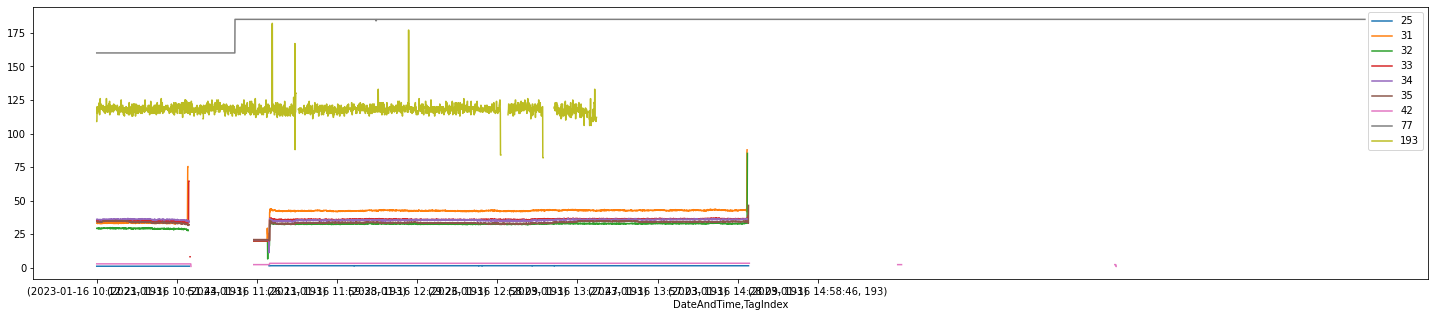

In [69]:
fig, ax = plt.subplots(figsize=(25,5))
indexed_values.groupby('TagIndex')['Val'].plot(figsize=(25,5), legend=True, ax = ax)

## 시계열간 Causality 분석

현재 개별 센서 또는 장비에서 출력되는 Sensor데이터는 해당 센서가 작업중인 공정물(Product)에 대한 시점 정보를 제공하지 않기 때문에, 
최종 점검 시점(193 번 메트릭)을 기준으로 개별 센서 데이터가 어는정도의 Leading Time을 가지고 있는지 계산할 필요가 있다. 

최종 결과를 판단하는 193번의 값의 경우, 개별 Metric값의 요동이 너무 심하므로, 전체적인 값을 Moving Average로 변경한다.



In [70]:
ma5 = indexed_values.groupby('TagIndex')['Val'].resample('5S', level=0).agg(['mean'])


한 화면에 이동 평균 값을 확인하기 위하여, subplot 객체를 생성하고, 이를 동일하게 이용하여, 한 화면에 도시하는 함수를 구성한다.

In [71]:
def show_ma(df):
  fig, ax = plt.subplots(figsize=(25,5))
  for key, grp in df.groupby('TagIndex'):
    ax.plot(grp.index.get_level_values(level=1),grp['mean'],label=key)
  ax.legend()

Sampling된 자료를 살펴본다.

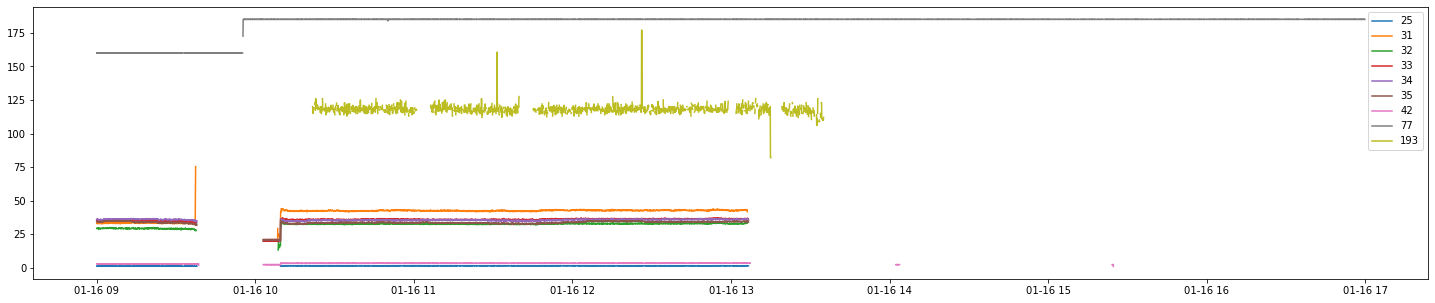

In [72]:
show_ma(ma5)

먼저 시계열자료가 부분부분, 누락되어 있는 것을 볼 수 있다. 

예들 들어, 193번 자료의 경우, 11시를 약간 넘긴 시점에서 약 5분간 자료 값이 들어오지 않은 것을 확인할 수 있다. 

실제로 원본 데이터 셋을 확인해 보기로 하자. 

In [73]:
mask = (
  (indexed_values.index.get_level_values(0) > '2023-01-16 11:01:10') &
  (indexed_values.index.get_level_values(0) < '2023-01-16 11:07:00') &
  (indexed_values.index.get_level_values(1) == 193)
)

indexed_values.loc[mask]

DateAndTime  Millitm     SensingTime   \
DateAndTime         TagIndex                                                  
2023-01-16 11:01:11 193       2023-01-16 11:01:11      692   1,673,866,871    
2023-01-16 11:01:12 193       2023-01-16 11:01:12      575   1,673,866,872    
2023-01-16 11:01:20 193       2023-01-16 11:01:20       15   1,673,866,880    
                    193       2023-01-16 11:01:20      494   1,673,866,880    
2023-01-16 11:01:28 193       2023-01-16 11:01:28      347   1,673,866,888    
2023-01-16 11:02:15 193       2023-01-16 11:02:15      698   1,673,866,935    
2023-01-16 11:04:22 193       2023-01-16 11:04:22      474   1,673,867,062    
2023-01-16 11:06:13 193       2023-01-16 11:06:13      281   1,673,867,173    
                    193       2023-01-16 11:06:13      799   1,673,867,173    
2023-01-16 11:06:21 193       2023-01-16 11:06:21      329   1,673,867,181    
                    193       2023-01-16 11:06:21      852   1,673,867,181    
2023-01-16 11:06:29 193       2023-01-16 11:06:29      240   1,673,867,189    
                    193       2023-01-16 11:06:29      713   1,673,867,189    
2023-01-16 11:06:36 193       2023-01-16 11:06:36      867   1,673,867,196    
2023-01-16 11:06:37 193       2023-01-16 11:06:37      374   1,673,867,197    
                    193       2023-01-16 11:06:37      877   1,673,867,197    
2023-01-16 11:06:45 193       2023-01-16 11:06:45       10   1,673,867,205    
                    193       2023-01-16 11:06:45      738   1,673,867,205    
2023-01-16 11:06:53 193       2023-01-16 11:06:53      298   1,673,867,213    
2023-01-16 11:06:55 193       2023-01-16 11:06:55       27   1,673,867,215    
                    193       2023-01-16 11:06:55      981   1,673,867,215    

                                Val Status             LeadTime  \
DateAndTime         TagIndex                                      
2023-01-16 11:01:11 193       119.0         2023-01-16 11:01:11   
2023-01-16 11:01:12 193       120.0         2023-01-16 11:01:12   
2023-01-16 11:01:20 193       115.0         2023-01-16 11:01:20   
                    193       115.0         2023-01-16 11:01:20   
2023-01-16 11:01:28 193         NaN         2023-01-16 11:01:28   
2023-01-16 11:02:15 193         NaN         2023-01-16 11:02:15   
2023-01-16 11:04:22 193         NaN         2023-01-16 11:04:22   
2023-01-16 11:06:13 193       111.0         2023-01-16 11:06:13   
                    193       111.0         2023-01-16 11:06:13   
2023-01-16 11:06:21 193       121.0         2023-01-16 11:06:21   
                    193       121.0         2023-01-16 11:06:21   
2023-01-16 11:06:29 193       119.0         2023-01-16 11:06:29   
                    193       119.0         2023-01-16 11:06:29   
2023-01-16 11:06:36 193       119.0         2023-01-16 11:06:36   
2023-01-16 11:06:37 193       119.0         2023-01-16 11:06:37   
                    193       117.0         2023-01-16 11:06:37   
2023-01-16 11:06:45 193       119.0         2023-01-16 11:06:45   
                    193       119.0         2023-01-16 11:06:45   
2023-01-16 11:06:53 193       116.0         2023-01-16 11:06:53   
2023-01-16 11:06:55 193       115.0         2023-01-16 11:06:55   
                    193       118.0         2023-01-16 11:06:55   

                              LeadTime_Epoch  LeadTimeGap  
DateAndTime         TagIndex                               
2023-01-16 11:01:11 193        1,673,866,871           -   
2023-01-16 11:01:12 193        1,673,866,872           -   
2023-01-16 11:01:20 193        1,673,866,880           -   
                    193        1,673,866,880           -   
2023-01-16 11:01:28 193        1,673,866,888           -   
2023-01-16 11:02:15 193        1,673,866,935           -   
2023-01-16 11:04:22 193        1,673,867,062           -   
2023-01-16 11:06:13 193        1,673,867,173           -   
                    193        1,673,867,173           -   
2023-01-16 11:06:2

보면, '11:01:12' 대역부터 자료가 누락되는 것을 확인할 수가 있다. 자료가 있다고 하더라도 '0' 또는 '1' 값이 들어와 정련과정에서 Null 처리 되었다. (자료상에는 NaN으로 표시) 
이후 약 5분간 이 상태가 유지된다.

향후 이 부분은 원인 파악이 필요할 것으로 보인다.

정상상태를 기준으로, 인과관계를 확인해 보자.

Graph를 보면, 대략 11시 50분에서 12시 50분까지 모든 Metric자료가 정상적인 형태를 띄운다.

해당하는 값을 추출해 보자.

In [74]:
filter_mask = (
  (ma5.index.get_level_values(1) > '2023-01-16 11:55:00') &
  (ma5.index.get_level_values(1) < '2023-01-16 12:50:00')
)

filtered = ma5.loc[filter_mask]

In [75]:
filtered

mean
TagIndex DateAndTime                    
25       2023-01-16 11:55:05    1.618250
         2023-01-16 11:55:10    1.618250
         2023-01-16 11:55:15    1.616750
         2023-01-16 11:55:20         NaN
         2023-01-16 11:55:25    1.621500
...                                  ...
193      2023-01-16 12:49:35  120.000000
         2023-01-16 12:49:40  120.000000
         2023-01-16 12:49:45  117.000000
         2023-01-16 12:49:50  115.666667
         2023-01-16 12:49:55         NaN

[5931 rows x 1 columns]

보면, NaN값이 있는 것을 확인할 수 있다. 해당 데이터는 앞에 데이터로 forward fill한다.


In [76]:
ffilled = filtered.ffill()
ffilled.columns = ['Val']
ffilled

Val
TagIndex DateAndTime                    
25       2023-01-16 11:55:05    1.618250
         2023-01-16 11:55:10    1.618250
         2023-01-16 11:55:15    1.616750
         2023-01-16 11:55:20    1.616750
         2023-01-16 11:55:25    1.621500
...                                  ...
193      2023-01-16 12:49:35  120.000000
         2023-01-16 12:49:40  120.000000
         2023-01-16 12:49:45  117.000000
         2023-01-16 12:49:50  115.666667
         2023-01-16 12:49:55  115.666667

[5931 rows x 1 columns]

보면, 인덱스가 Tag Index / Date 기준으로 잡혀있다. Time Series 분석을 하기 전에, Index 순서를 변경하고, Tag Index를 Column으로 올려준다. (Unstack)

In [77]:
date_first_df = ffilled.swaplevel(0,1).unstack()

값이 정상적으로 나오는지 확인해본다.

In [78]:
date_first_df

Val                                              \
TagIndex                 25         31         32         33         34    
DateAndTime                                                                
2023-01-16 11:55:05  1.61825  43.220001  32.860001  36.450001  35.650002   
2023-01-16 11:55:10  1.61825  43.220001  32.860001  36.450001  35.650002   
2023-01-16 11:55:15  1.61675  43.070000  33.180000  36.450001  35.796668   
2023-01-16 11:55:20  1.61675  43.070000  33.180000  36.450001  35.796668   
2023-01-16 11:55:25  1.62150  42.910000  32.860001  36.130001  35.650002   
...                      ...        ...        ...        ...        ...   
2023-01-16 12:49:35  1.58975  43.003334  32.980000  36.543332  36.136665   
2023-01-16 12:49:40  1.59200  42.950001  33.299999  36.730000  36.189999   
2023-01-16 12:49:45  1.59225  43.110001  33.139999  36.430000  36.349998   
2023-01-16 12:49:50  1.59325  42.630001  33.030000  36.433333  36.083332   
2023-01-16 12:49:55  1.59325  42.630001  33.030000  36.433333  36.083332   

                                                         
TagIndex                   35    42     77          193  
DateAndTime                                              
2023-01-16 11:55:05  33.250000  3.42  185.0  119.000000  
2023-01-16 11:55:10  33.250000  3.42  185.0  119.000000  
2023-01-16 11:55:15  33.570000  3.42  185.0  118.333333  
2023-01-16 11:55:20  33.570000  3.42  185.0  118.333333  
2023-01-16 11:55:25  33.570000  3.42  185.0  118.000000  
...                        ...   ...    ...         ...  
2023-01-16 12:49:35  34.446667  3.45  185.0  120.000000  
2023-01-16 12:49:40  34.500000  3.45  185.0  120.000000  
2023-01-16 12:49:45  34.830002  3.45  185.0  117.000000  
2023-01-16 12:49:50  34.180000  3.45  185.0  115.666667  
2023-01-16 12:49:55  34.180000  3.45  185.0  115.666667  

[659 rows x 9 columns]

상관관계 분석을 편리하게 할 수 있는 함수를 생성해본다.

해당 함수는, 두개의 dataframe을 받은 후에, 두번째 데이터프레임에 lag 함수를 지정하여, 타임프레임을 뒤로 옮기는 역활을 한다. 

만약, lag값이 10으로 주어지고, sampling을 5초간격으로 했다고 가정할 경우, 약 50초 이후값으로 치환되는 효과를 가져간다. 

주의할 점은, 후행 공정이 앞으로 와야 하며, 선행 공정은 lag 를 적용하여, 후행공정과의 시간간격을 체크하는 용도로 활용한다.

In [79]:
def crosscorr(x, y, lag=0):
    return x.corr(y.shift(lag))



비교하려는 공전간 Leading Time을 최대 1000초로 가정하고, 

이를 위하여 lag point를 200(200 * 5초니까 1000초) 으로 잡는다

In [80]:
lagdf = pd.DataFrame(range(200))

In [81]:
lagdf.columns = ['lagtime']
lagdf.set_index('lagtime')

""
lagtime
0
1
2
3
4
...
195
196
197


In [82]:
lagdf2 = lagdf.copy()


In [83]:
lagdf2['corr_25_31']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',25)], date_first_df[('Val',31)], lag=row.lagtime), axis=1)
lagdf2['corr_25_32']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',25)], date_first_df[('Val',32)], lag=row.lagtime), axis=1)
lagdf2['corr_25_33']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',25)], date_first_df[('Val',33)], lag=row.lagtime), axis=1)
lagdf2['corr_25_34']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',25)], date_first_df[('Val',34)], lag=row.lagtime), axis=1)
lagdf2['corr_25_35']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',25)], date_first_df[('Val',35)], lag=row.lagtime), axis=1)

In [84]:
lagdf2

,lagtime,corr_25_31,corr_25_32,corr_25_33,corr_25_34,corr_25_35
0,0,0.179962,0.087341,0.008033,-0.164537,-0.261480
1,1,0.184623,0.136758,0.029580,-0.119223,-0.239512
2,2,0.177053,0.141083,0.062706,-0.085897,-0.226626
3,3,0.150870,0.084995,0.066096,-0.089913,-0.238890
4,4,0.160225,0.078888,0.067681,-0.107778,-0.250979
...,...,...,...,...,...,...
195,195,0.093013,-0.024094,-0.013679,0.032592,-0.093901
196,196,0.120701,0.003952,-0.020926,0.015820,-0.096496
197,197,0.055457,-0.030031,-0.057805,-0.023390,-0.103926
198,198,0.072905,-0.025928,-0.029248,0.019915,-0.093216


제면 두께와 롤로 속도와의 상관관계를 lag time의 변화를 계산하였다. 

이를 Graph로 확인해 보자

<AxesSubplot:>

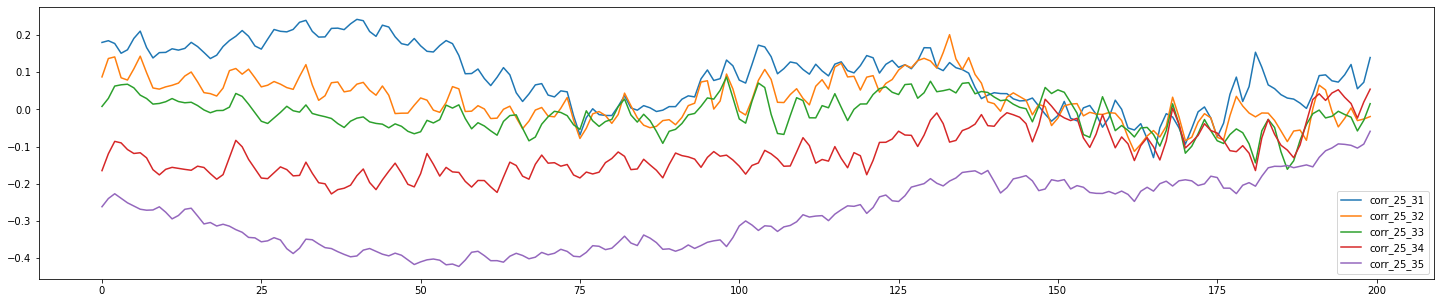

In [85]:
lagdf2[['corr_25_31','corr_25_32','corr_25_33','corr_25_34','corr_25_35']].plot(figsize=(25,5))


위 데이터를 보면, 35번 (최종 롤러) 자료의 275초(55 * 5) 정도에 롤러 속도와 역관계를 형성하고 있다. 
(즉, 롤러 속도가 빠를 경우, 제면 두께는 얇아 진다. 하지만 매우 약한 관계로 보임)

하지만, 실제 공장 상황을 보면, (참고 화면. https://youtu.be/JjqMfFVD-p4?t=135)

롤러1(31)번과 제면 두께 센서와는 상단한 거리차이가 있어서 백 초 넘게 차이가 발생할 수 있지만, 
가장 지근 거리에 있는 롤러(35)가 275초의 차이를 두고, 제면 두께 센서(25)와 영향을 주고 받는 것은 무리가 있는 가정이다. 

정리하면 아래와 같다. 

- 먼저, 각 Tag에 대한 센서 위치에 대한 정확한 정보의 재확인이 필요하다. 
- 만약, 위 그래프대로의 설명을 한다면, 
  - Roller 1,2 번의 경우, 속도가 빠를 경우, 제면 두께가 두꺼워지는 경향이 있고, 
  - Roller 4,5 번의 경우, 속도가 빠를 경우, 제면 두께가 얇아지는 경향성이 아주 약간 있다.
- Roller 1번이, 제면 두께 센서를 통과하는 시점은 (Lead Time)은 150초 정도 걸리는 것으로 보인다.  

롤러와 제면 두께간의 관계와는 별도로, 만약 제면두께와 증숙면 중량간에 상관관계가 있다면, 롤러와 증숙면 중량간에도 유사한 graph가 그려질 것으로 예상된다. 

또한, 중숙면 무게 센서와, 제면 두께 센서의 위치가 동일할 경우 위와 동일한 Leading Time이 발생할 것이다. 이를 확인해 보자.

In [86]:
lagdf3 = lagdf.copy()


In [87]:
lagdf3['corr_77_31']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',77)], date_first_df[('Val',31)], lag=row.lagtime), axis=1)
lagdf3['corr_77_32']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',77)], date_first_df[('Val',32)], lag=row.lagtime), axis=1)
lagdf3['corr_77_33']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',77)], date_first_df[('Val',33)], lag=row.lagtime), axis=1)
lagdf3['corr_77_34']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',77)], date_first_df[('Val',34)], lag=row.lagtime), axis=1)
lagdf3['corr_77_35']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',77)], date_first_df[('Val',35)], lag=row.lagtime), axis=1)

하지만, 실제 증숙면 중량은, 모든 값이 185로 동일하기 때문에, 상관 관계를 구할 수 없다. 

실제 증숙면 중량이, 185.0으로 동일할 수가 있는지 확인 필요하다.

현재로서는, 증숙면 중량 값은 상수로 들어와서 사용할 수가 없으며, 유탕 온도도 동일하므로 사용할 수 없다.


마지막으로 

1. 웨이브 컨베이어 속도(42)와 유탕 중량 선별기(193), 
2. 제면두께(25)와 유탕 중량 선별기(193)

간의 관계를 확인해 보자.


In [88]:
lagdf4 = lagdf.copy()

In [89]:
lagdf4['corr_193_42']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',193)], date_first_df[('Val',42)], lag=row.lagtime), axis=1)
lagdf4['corr_193_25']=lagdf.apply(lambda row: crosscorr(date_first_df[('Val',193)], date_first_df[('Val',25)], lag=row.lagtime), axis=1)

<AxesSubplot:>

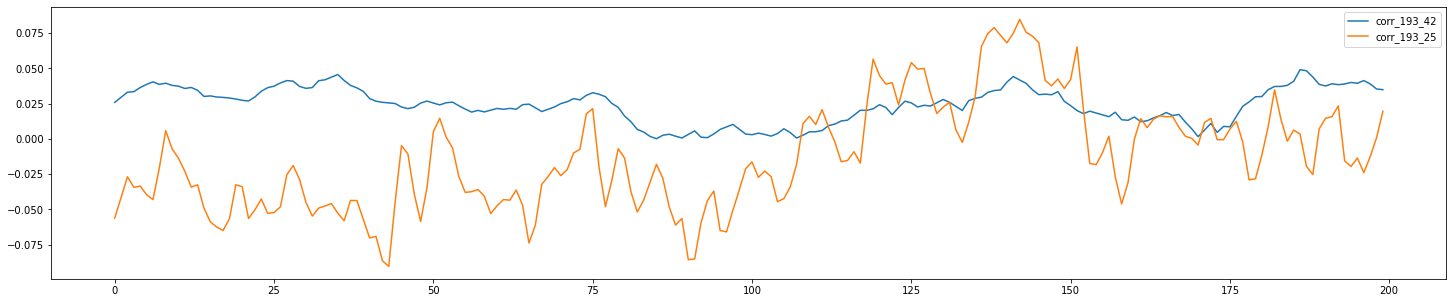

In [90]:
lagdf4[['corr_193_42','corr_193_25']].plot(figsize=(25,5))

In [91]:
lagdf4.loc[lagdf4.corr_193_25 == lagdf4['corr_193_25'].max()]

,lagtime,corr_193_42,corr_193_25
142,142,0.041801,0.084821


서로 다른 leading타임을 주고, 상관 계수를 확인하면, 

대략, 142 * 5 = 710초 정도 선행하는 것으로 보인다. 

즉 건면 두께가 두꺼워질 수록 선별기 값이 커질 수 있으며 그 시간차는 142정도로 보여진다. (실제 공정 시간 확인 필요)

웨이브롤러의 경우도 유사한 결과치(leading time 710초)를 보이는 것을 확인할 수 있다. 

### 상관관계에 대한 결론

1. 현재 상태로는 센서의 정확한 위치를 특정할 수 없다
2. 롤러와 제면 센서간의 Leading Time을 확정할 수 없다
3. 롤러에 따라 제면 두께와는 일부 정/부 상관관계가 보인다 (인과 관계는 미확인)
4. 중숙면 중량의 모든 값이 일정한 것은 확인할 필요가 있다
5. 제면 두께와, 웨이브 컨베이어 속도는 선별기와 710초 (142 point)와 약한 상관관계를 가지고 있다.

## 회귀 분석

선행 공정인 롤러 속도와 제면 두께 센서와의 Leading Time 관계는 현재 특정할 수 없으므로, 

웨이브 컨베이어와, 제면 두께 (이하 Tag 42, Tag 25로 지정) 이 두가지 Factor를 가지고, 선별기 결과를 설명할 수 있는 회귀식을 구한다. 

먼저, Tag 42, Tag 25 자료를 시간 천이를 진행 (142 point, 710초) 시킨다.

In [92]:
timeshifted_df = pd.DataFrame()
timeshifted_df[['Val193']] = date_first_df[[('Val', 193)]]


In [93]:
timeshifted_df[['Val25']] = date_first_df[[('Val',25)]].shift(142)
timeshifted_df[['Val42']] = date_first_df[[('Val',42)]].shift(142)

시간축을 이동하여, 비어있는 부분을 제거한다.

In [94]:
refined_timeshifted_df = timeshifted_df.dropna()

자료 정련이 완료되었다. 

이제, 통계 모델을 적용하여, 선형회귀분석을 수행해 보자

In [95]:
import statsmodels.api as sm

model = sm.OLS(refined_timeshifted_df['Val193'], sm.add_constant(refined_timeshifted_df[['Val25','Val42']]))
result = model.fit()

/home/postgres/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [96]:
print(result.pvalues)

const    0.182859
Val25    0.016711
Val42    0.087669
dtype: float64


실제로 나온 선형 회귀 분석 모형에 대해서, 예측치를 구해본다.

In [97]:
refined_timeshifted_df['Pre193'] = result.predict(sm.add_constant(refined_timeshifted_df[['Val25','Val42']]))

/home/postgres/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/tmp/ipykernel_1898/1025254423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refined_timeshifted_df['Pre193'] = result.predict(sm.add_constant(refined_timeshifted_df[['Val25','Val42']]))


<AxesSubplot:xlabel='DateAndTime'>

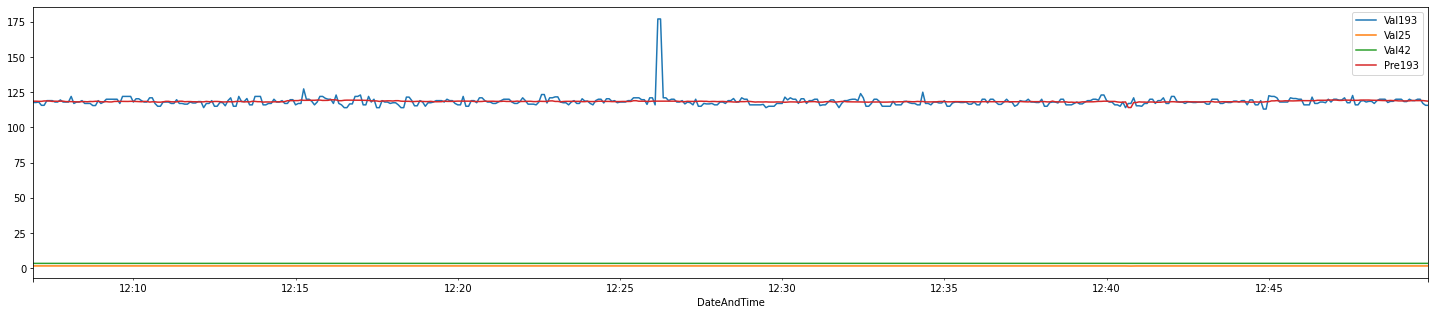

In [98]:
refined_timeshifted_df.plot(figsize=(25,5))

In [99]:
refined_timeshifted_df

,Val193,Val25,Val42,Pre193
DateAndTime,,,,
2023-01-16 12:06:55,117.666667,1.618250,3.42,118.587276
2023-01-16 12:07:00,117.666667,1.618250,3.42,118.587276
2023-01-16 12:07:05,118.000000,1.616750,3.42,118.496941
2023-01-16 12:07:10,115.666667,1.616750,3.42,118.496941
2023-01-16 12:07:15,115.666667,1.621500,3.42,118.783001
...,...,...,...,...
2023-01-16 12:49:35,120.000000,1.604583,3.44,119.000865
2023-01-16 12:49:40,120.000000,1.605167,3.44,119.035993
2023-01-16 12:49:45,117.000000,1.605167,3.44,119.035993


일반 선형 회귀 방정식으로는 이상치 예측이 어려운 것으로 보이며, 이를 우회하기 위하여, log 변환 후 선형 회귀를 진행해 보도록 한다.

In [100]:
import numpy as np

log_df = pd.DataFrame()
log_df[['Val193','Val25','Val42']] = refined_timeshifted_df[['Val193','Val25','Val42']].applymap(np.log2)

<AxesSubplot:xlabel='DateAndTime'>

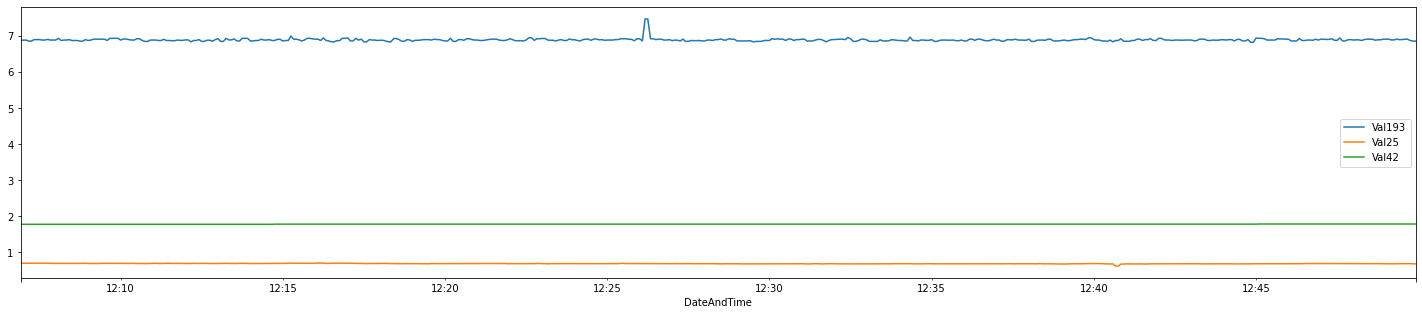

In [101]:
log_df.plot(figsize=(25,5))

In [102]:
log_model = sm.OLS(log_df['Val193'], sm.add_constant(log_df[['Val25','Val42']]))
log_result = log_model.fit()

/home/postgres/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [103]:
log_df['Pre193'] = log_result.predict(sm.add_constant(log_df[['Val25','Val42']]))

<AxesSubplot:xlabel='DateAndTime'>

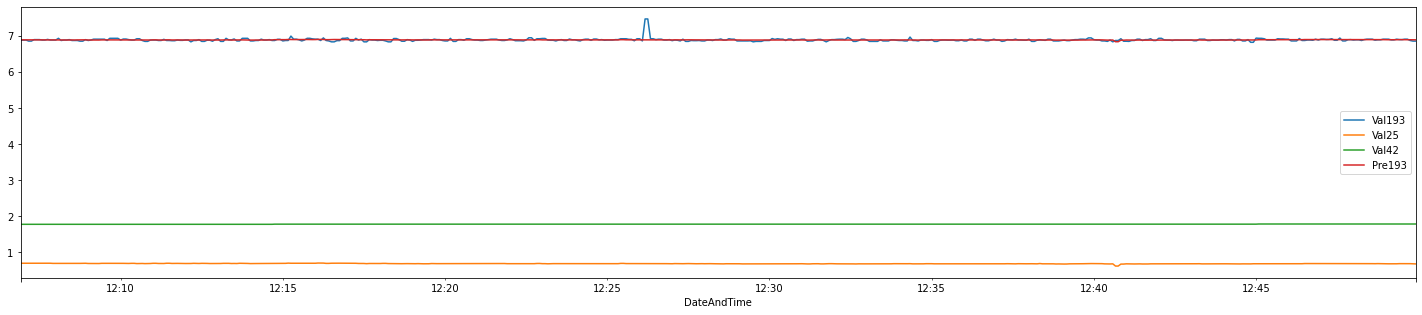

In [104]:
log_df.plot(figsize=(25,5))

보는 바와 같이, Log 값을 적용한 모델에서도 선별기와, 제면 두께, 벨트 속도간의 관계로만, 이상치 발견은 어렵다는 것을 확인할 수 있다. 

하지만, 미세하게 변하는, 선별기 표준 중량에 대해서는, 제면 두께, 벨트 속도를 통하여, 어는 정도 예측치와 일치하는 것을 확인할 수 있다.

### 결론

1. 현재 이용할 수 있는 자료만으로 이상치 판별을 진행하는 것은 시간이 많이 걸릴 것으로 보인다. 
2. 자료 정합성이 높을 경우, 다양한 Tag값을 이용하여 자료 판별에 활용할 수 있을 것으로 보인다
3. 현재 자료를 통해서도, 선별기에서 통과하는 표준 중량에 대한 부분은 어는 정도 예측이 가능하다.
